#### GLDADec on lung pseudo bulk dataset
- The single-cell transcriptome data for cells isolated from human lung tissue was sourced from the Tissue Stability Cell Atlas (TSCA). A pseudo-bulk dataset was generated comprising five immune cell types (CD4+ T cells, cytotoxic T cells, mast cells, monocytes, and NK cells) and four lung background cell types (alveolar type I, alveolar type II, ciliated cells, and fibroblasts).
- We collected marker gene names from CellMarker database.
- Corresponding to FIg. S18.

In [1]:
import codecs
import collections
import itertools

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

BASE_DIR = '/workspace/github/GLDADec' # cloning repository
import sys
sys.path.append(BASE_DIR)

from run import pipeline
from _utils import gldadec_processing

***
##### Load data

In [2]:
raw_df = pd.read_csv(BASE_DIR+'/data/PseudoBulk/pseudo_lung_expression.csv',index_col=0)
random_sets = pd.read_pickle(BASE_DIR+'/data/random_info/100_random_sets.pkl')
ground_truth = pd.read_csv(BASE_DIR+'/data/PseudoBulk/ground_truth_proportion.csv',index_col=0)

raw_df.columns = [str(t) for t in raw_df.columns]
ground_truth.index = [str(t) for t in ground_truth.index]

***
##### Marker processing

In [3]:
# %% Marker prep
# load total data
with codecs.open(BASE_DIR + '/data/marker/raw_info/CellMarker/Cell_marker_All.csv', "r", "Shift-JIS", "ignore") as file:
    total_ref = pd.read_table(file, delimiter=",")

# human
human_ref = total_ref[total_ref["species"].isin(["Human"])] # 60877
target_tissues = ['Lung']
target_ref = human_ref[human_ref['tissue_class'].isin(target_tissues)]

# 'Fibroblast','Ciliated','Alveolar_Type1','Alveolar_Type2'
# Fibroblast
fibcandi = target_ref[target_ref['cell_name'].isin(['Fibroblast','Myofibroblast'])]
fibcandi = fibcandi[fibcandi['marker_source'].isin(['Experiment', 'Review', 'Company'])]
fibcandi = fibcandi['Symbol'].dropna().unique().tolist()

# Ciliated
cilicandi = target_ref[target_ref['cell_name'].isin(['Ciliated cell'])]
cilicandi = cilicandi[cilicandi['marker_source'].isin(['Experiment', 'Review', 'Company'])]
cilicandi = cilicandi['Symbol'].dropna().unique().tolist()

# Alveolar_Type1
at1candi = target_ref[target_ref['cell_name'].isin(['Alveolar cell Type 1','Alveolar epithelial cell Type 1'])]
at1candi = at1candi[at1candi['marker_source'].isin(['Experiment', 'Review', 'Company'])]
at1candi = at1candi['Symbol'].dropna().unique().tolist()

# Alveolar Type2
at2candi = target_ref[target_ref['cell_name'].isin(['Alveolar cell Type 2','Alveolar epithelial cell Type 2'])]
at2candi = at2candi[at2candi['marker_source'].isin(['Experiment', 'Review', 'Company'])]
at2candi = at2candi['Symbol'].dropna().unique().tolist()

domain_dic = pd.read_pickle(BASE_DIR+'/data/marker/human_blood_domain.pkl')

# CD4 cells
cd4candi = []
cd4candi.extend(domain_dic.get('T cells CD4 memory'))
#cd4candi.extend(domain_dic.get('T cells CD4 naive'))

# Cytotoxic cells
ctcandi =  domain_dic.get('T cells CD8')

# NK cells
nkcandi = domain_dic.get('NK cells')
nkcandi = ['CX3CR1', 'IL2RB', 'PTPRC', 'SELL'] # remove 'FCGR3A' , 'FCGR3B'

# Monocytes
moncandi = domain_dic.get('Monocytes')

# Mast cells
mastcandi = target_ref[target_ref['cell_name'].isin(['Mast cell'])]
mastcandi = mastcandi[mastcandi['marker_source'].isin(['Experiment', 'Review', 'Company'])]
mastcandi = mastcandi['Symbol'].dropna().unique().tolist()


# generate original marker dict
k =  ['Fibroblast','Ciliated','Alveolar-Type1','Alveolar-Type2']+['CD4+ T','Cytotoxic T','NK cells','Monocytes','Mast cells']
v = [fibcandi,cilicandi,at1candi,at2candi]+[cd4candi,ctcandi,nkcandi,moncandi,mastcandi]
final_dic = dict(zip(k,v))


  0%|          | 0/10 [00:00<?, ?it/s]

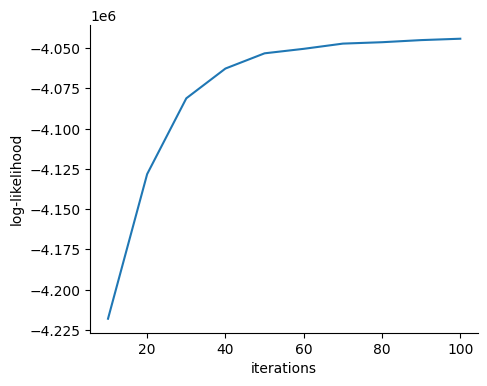

cells in res : ['Fibroblast', 'Ciliated', 'Alveolar-Type1', 'Alveolar-Type2', 'CD4+ T', 'Cytotoxic T', 'NK cells', 'Monocytes', 'Mast cells']
cells in ref : ['NK', 'T_CD4', 'T_CD8_CytT', 'Monocyte', 'Mast_cells', 'Fibroblast', 'Ciliated', 'Alveolar_Type1', 'Alveolar_Type2']


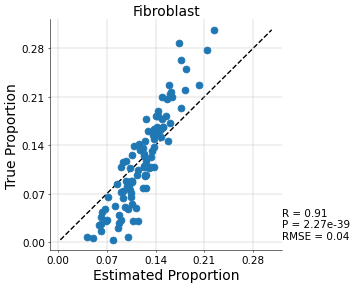

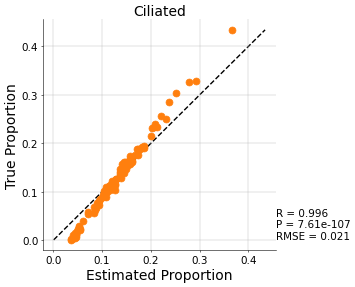

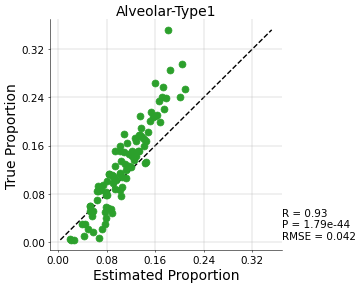

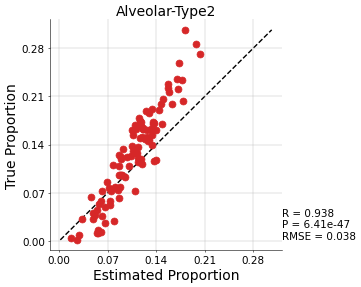

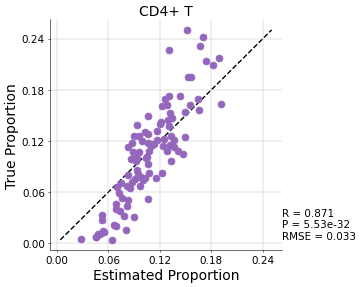

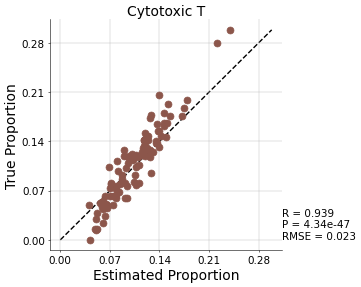

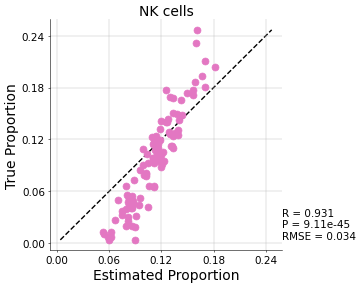

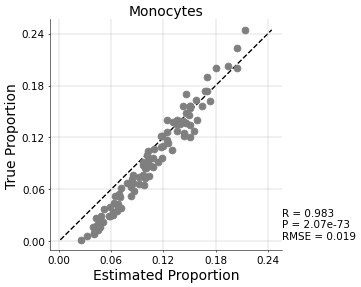

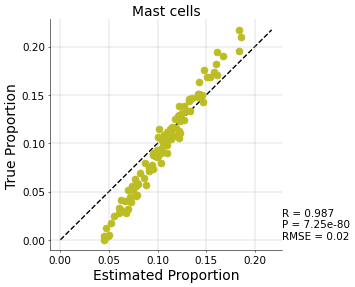

{'Alveolar-Type1': [('R', 0.9303), ('P', '1.79e-44'), ('RMSE', 0.0415)],
 'Alveolar-Type2': [('R', 0.9381), ('P', '6.41e-47'), ('RMSE', 0.0385)],
 'CD4+ T': [('R', 0.8708), ('P', '5.53e-32'), ('RMSE', 0.0327)],
 'Ciliated': [('R', 0.9964), ('P', '7.61e-107'), ('RMSE', 0.021)],
 'Cytotoxic T': [('R', 0.9386), ('P', '4.34e-47'), ('RMSE', 0.0229)],
 'Fibroblast': [('R', 0.9105), ('P', '2.27e-39'), ('RMSE', 0.0396)],
 'Mast cells': [('R', 0.9872), ('P', '7.25e-80'), ('RMSE', 0.0204)],
 'Monocytes': [('R', 0.9826), ('P', '2.07e-73'), ('RMSE', 0.0191)],
 'NK cells': [('R', 0.9313), ('P', '9.11e-45'), ('RMSE', 0.0342)]}


In [4]:
# Conduct GLDADec
pp = pipeline.Pipeline(verbose=False)
pp.from_predata(raw_df,target_samples=[],
                    do_ann=False,linear2log=False,log2linear=False,do_drop=True,do_batch_norm=False,do_quantile=False,remove_noise=False)

pp.gene_selection(method='CV',outlier=True,topn=100)
pp.add_marker_genes(target_cells=['Fibroblast', 'Ciliated', 'Alveolar-Type1', 'Alveolar-Type2', 'CD4+ T', 'Cytotoxic T', 'NK cells', 'Monocytes', 'Mast cells'],add_dic=final_dic)


pp.deocnv_prep(random_sets=random_sets,do_plot=False,specific=True,prior_norm=True,norm_scale=100,minmax=False,mm_scale=10)
pp.deconv(n=10,add_topic=0,n_iter=100,alpha=0.01,eta=0.01,refresh=10,initial_conf=1.0,seed_conf=1.0,other_conf=0.0,ll_plot=True,var_plot=False)

res = pp.merge_total_res
pp.evaluate(facs_df=ground_truth,deconv_norm_range=['Fibroblast', 'Ciliated', 'Alveolar-Type1', 'Alveolar-Type2', 'CD4+ T', 'Cytotoxic T', 'NK cells', 'Monocytes', 'Mast cells'],
            facs_norm_range=['NK', 'T_CD4', 'T_CD8_CytT', 'Monocyte', 'Mast_cells', 'Fibroblast', 'Ciliated', 'Alveolar_Type1', 'Alveolar_Type2'],
            res_names=[['Fibroblast'],['Ciliated'],['Alveolar-Type1'],['Alveolar-Type2'],['CD4+ T'],['Cytotoxic T'],['NK cells'],['Monocytes'],['Mast cells']],
            ref_names=[['Fibroblast'],['Ciliated'],['Alveolar_Type1'],['Alveolar_Type2'],['T_CD4'], ['T_CD8_CytT'],['NK'], ['Monocyte'], ['Mast_cells']],
            title_list = ['Fibroblast', 'Ciliated', 'Alveolar-Type1', 'Alveolar-Type2', 'CD4+ T', 'Cytotoxic T', 'NK cells', 'Monocytes', 'Mast cells'],
            figsize=(6,6),dpi=50,plot_size=100,multi=False)
